In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import warnings
import copy
import os
warnings.filterwarnings("ignore")
from sys import getsizeof
import re


In [2]:
# 数据分析
targets = ['top_年化收益率ER','top_年化波动率VOL','top_夏普比率SR','top_换手率Tov',
           'bottom_年化收益率ER','bottom_年化波动率VOL', 'bottom_夏普比率SR','bottom_换手率Tov',]
filename = 'XSMOM_report_median_grouped.csv'
XSMOM_report = pd.read_csv(filename,usecols=targets,encoding='gbk')
index = pd.read_csv(filename,usecols=[0],encoding='gbk')
XSMOM_report['description'] = index


label=list(XSMOM_report['description'].apply(lambda x : x[3:].split('天')))
window_label = [int(x[0]) for x in label]
description_label = [x[1][3:] for x in label]
XSMOM_report['window_label'],XSMOM_report['description_label'] = window_label, description_label
XSMOM_report['function_name'] = XSMOM_report['description_label'].apply(lambda x : '_'.join(x.split('_')[:-1]))
XSMOM_report.drop(['description'],axis=1, inplace=True)
display(XSMOM_report)

top_年化收益率ER  top_年化波动率VOL  top_夏普比率SR  top_换手率Tov  bottom_年化收益率ER  \
0       0.025467      0.023614    1.078483    0.224122       -0.024814   
1       0.049074      0.030531    1.607349    0.286548       -0.037937   
2       0.031234      0.031750    0.983755    0.286142       -0.037323   
3       0.043307      0.030714    1.410008    0.477595       -0.091310   
4       0.091310      0.078454    1.163878    0.906650       -0.043307   
..           ...           ...         ...         ...             ...   
343     0.037849      0.025686    1.473513    0.149430       -0.039238   
344     0.052804      0.026897    1.963183    0.089478       -0.026787   
345     0.049787      0.023262    2.140269    0.137051       -0.044211   
346     0.026018      0.023311    1.116094    0.061559       -0.020648   
347     0.004978      0.009010    0.552446    0.028163       -0.019781   

     bottom_年化波动率VOL  bottom_夏普比率SR  bottom_换手率Tov  window_label  \
0           0.015414      -1.609796       0.170308             5   
1           0.020614      -1.840320       0.245673             5   
2           0.021599      -1.727948       0.268144             5   
3           0.078454      -1.163878       0.906650             5   
4           0.030714      -1.410008       0.477595             5   
..               ...            ...            ...           ...   
343         0.030654      -1.280013       0.176210           252   
344         0.021097      -1.269696       0.095727           252   
345         0.028320      -1.561134       0.114087           252   
346         0.016172      -1.276755       0.060018           252   
347         0.007220      -2.739727       0.029436           252   

                                     description_label     function_name  
0                                 abs_energy_时间序列的绝对能量        abs_energy  
1                                        abs_max_最高绝对值           abs_max  
2                              abs_sum_changes_一阶差分绝对和   abs_sum_changes  
3                            count_above_mean_高于均值个数占比  count_above_mean  
4                            count_below_mean_低于均值个数占比  count_below_mean  
..                                                 ...               ...  
343                            num_cwt_peaks_搜索x中的不同峰值     num_cwt_peaks  
344                    partial_autocorr_给定滞后结束的偏相关函数的值  partial_autocorr  
345                                  permu_entropy_排列熵     permu_entropy  
346                           spkt_welch_dens_不同频率的功率谱   spkt_welch_dens  
347  ti_rev_asym_stat_时间反转不对称统计量 (time reversal asy...  ti_rev_asym_stat  

[348 rows x 11 columns]

In [3]:
time_windows = list(set(XSMOM_report['window_label']))
time_windows.sort()

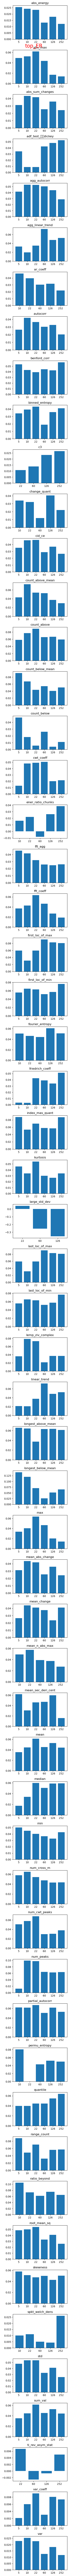

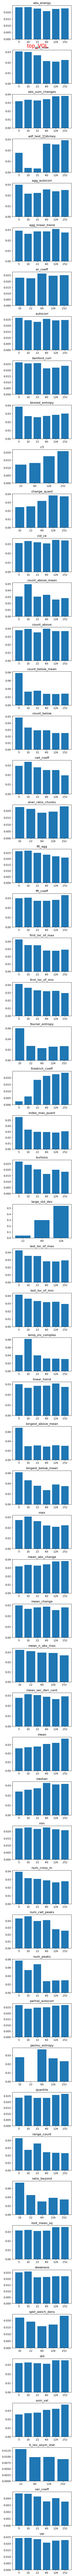

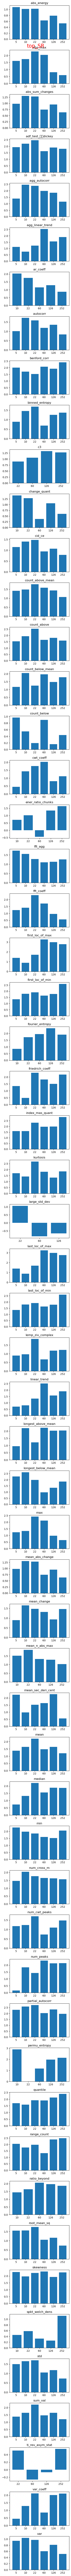

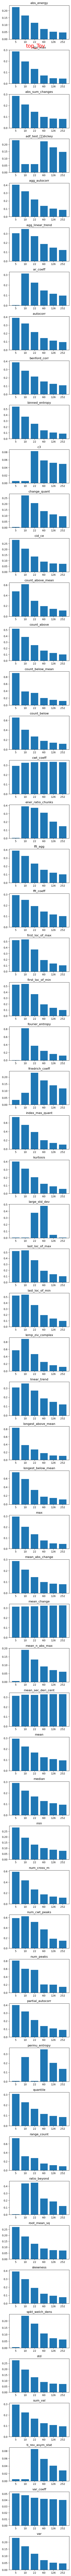

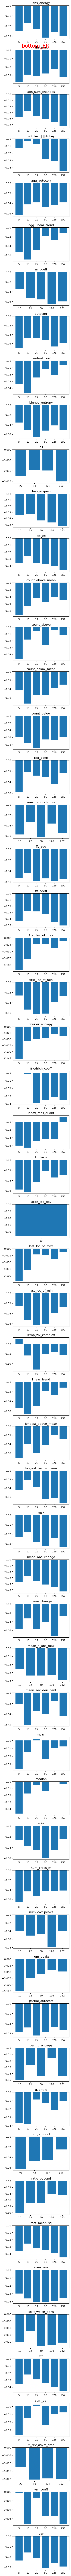

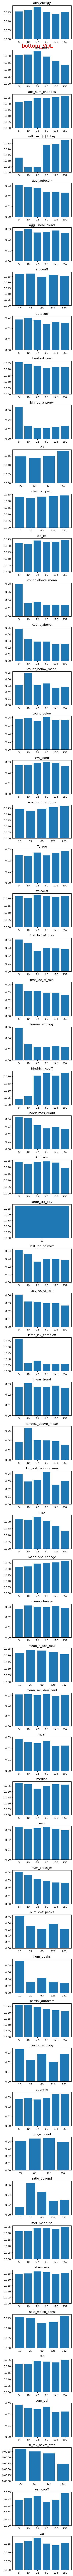

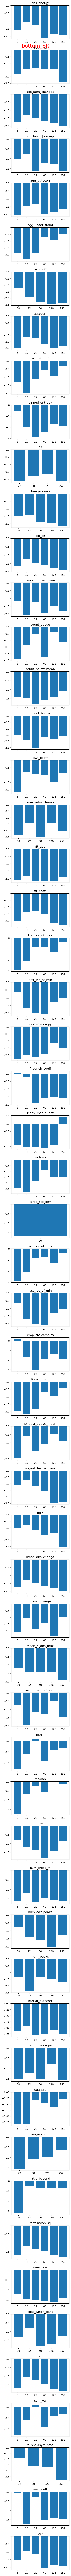

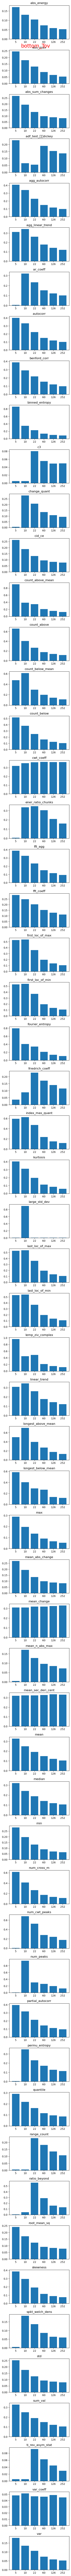

In [10]:
# 区分不同的采样频率
horizontal_group = XSMOM_report.groupby(['description_label'])
horizontal_dict = dict(list(horizontal_group))
count = len(horizontal_dict)
ncols = 1
nrows = count // ncols + 1


# display(horizontal_dict)
for name in targets:

    i = 1
    plt.figure(figsize=(4 , 9 * 4 * 4))

    for key, value in horizontal_dict.items():
        plt.subplot(nrows, ncols, i)
        x = [str(i) for i in list(value['window_label'])]
        plt.bar(x,value[name])
        
        plt.title(value['function_name'].iloc[0])
        i += 1

    name = re.sub('[\u4e00-\u9fa5]', '', name)
    plt.suptitle(name, fontsize=20,color='r')
    plt.tight_layout() 
    plt.savefig(name + "_sampling_freq.png")
    plt.show()
    

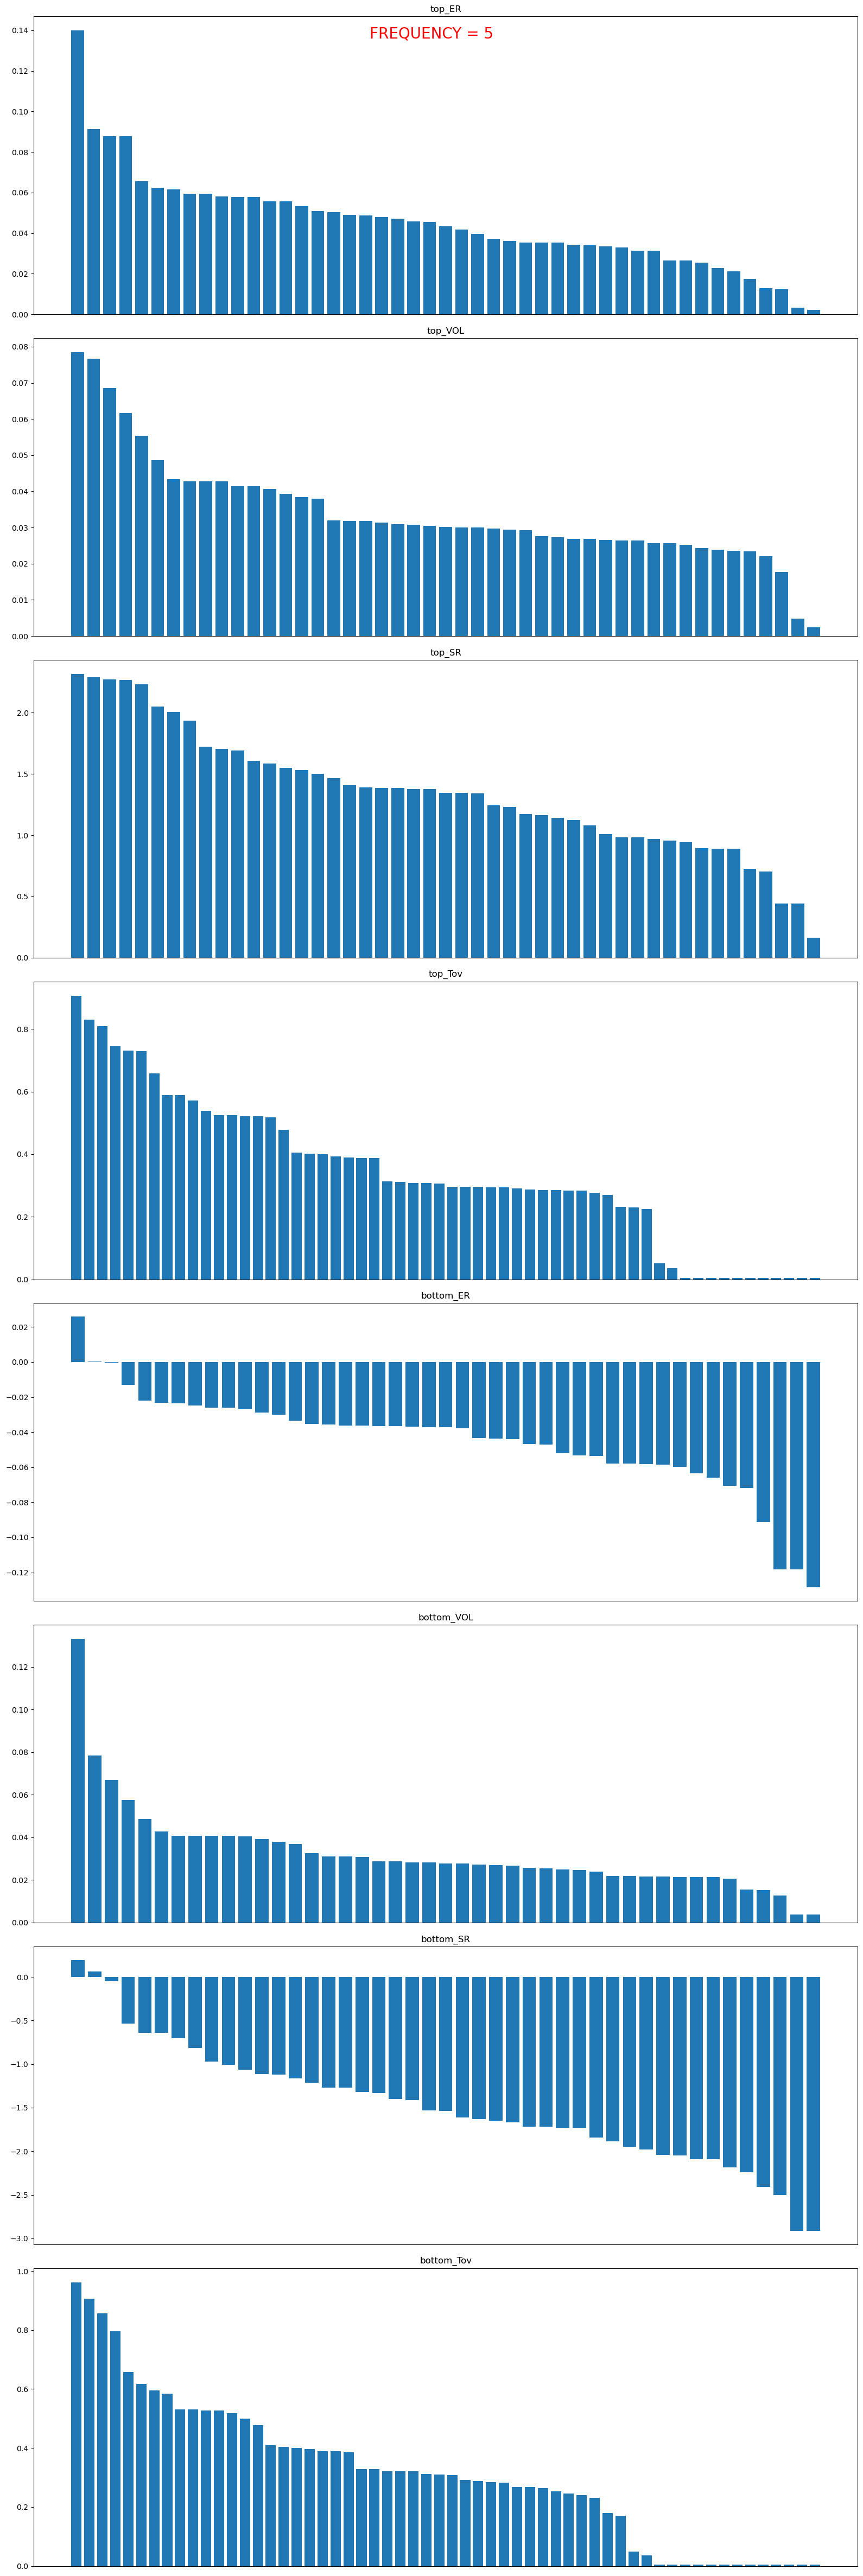

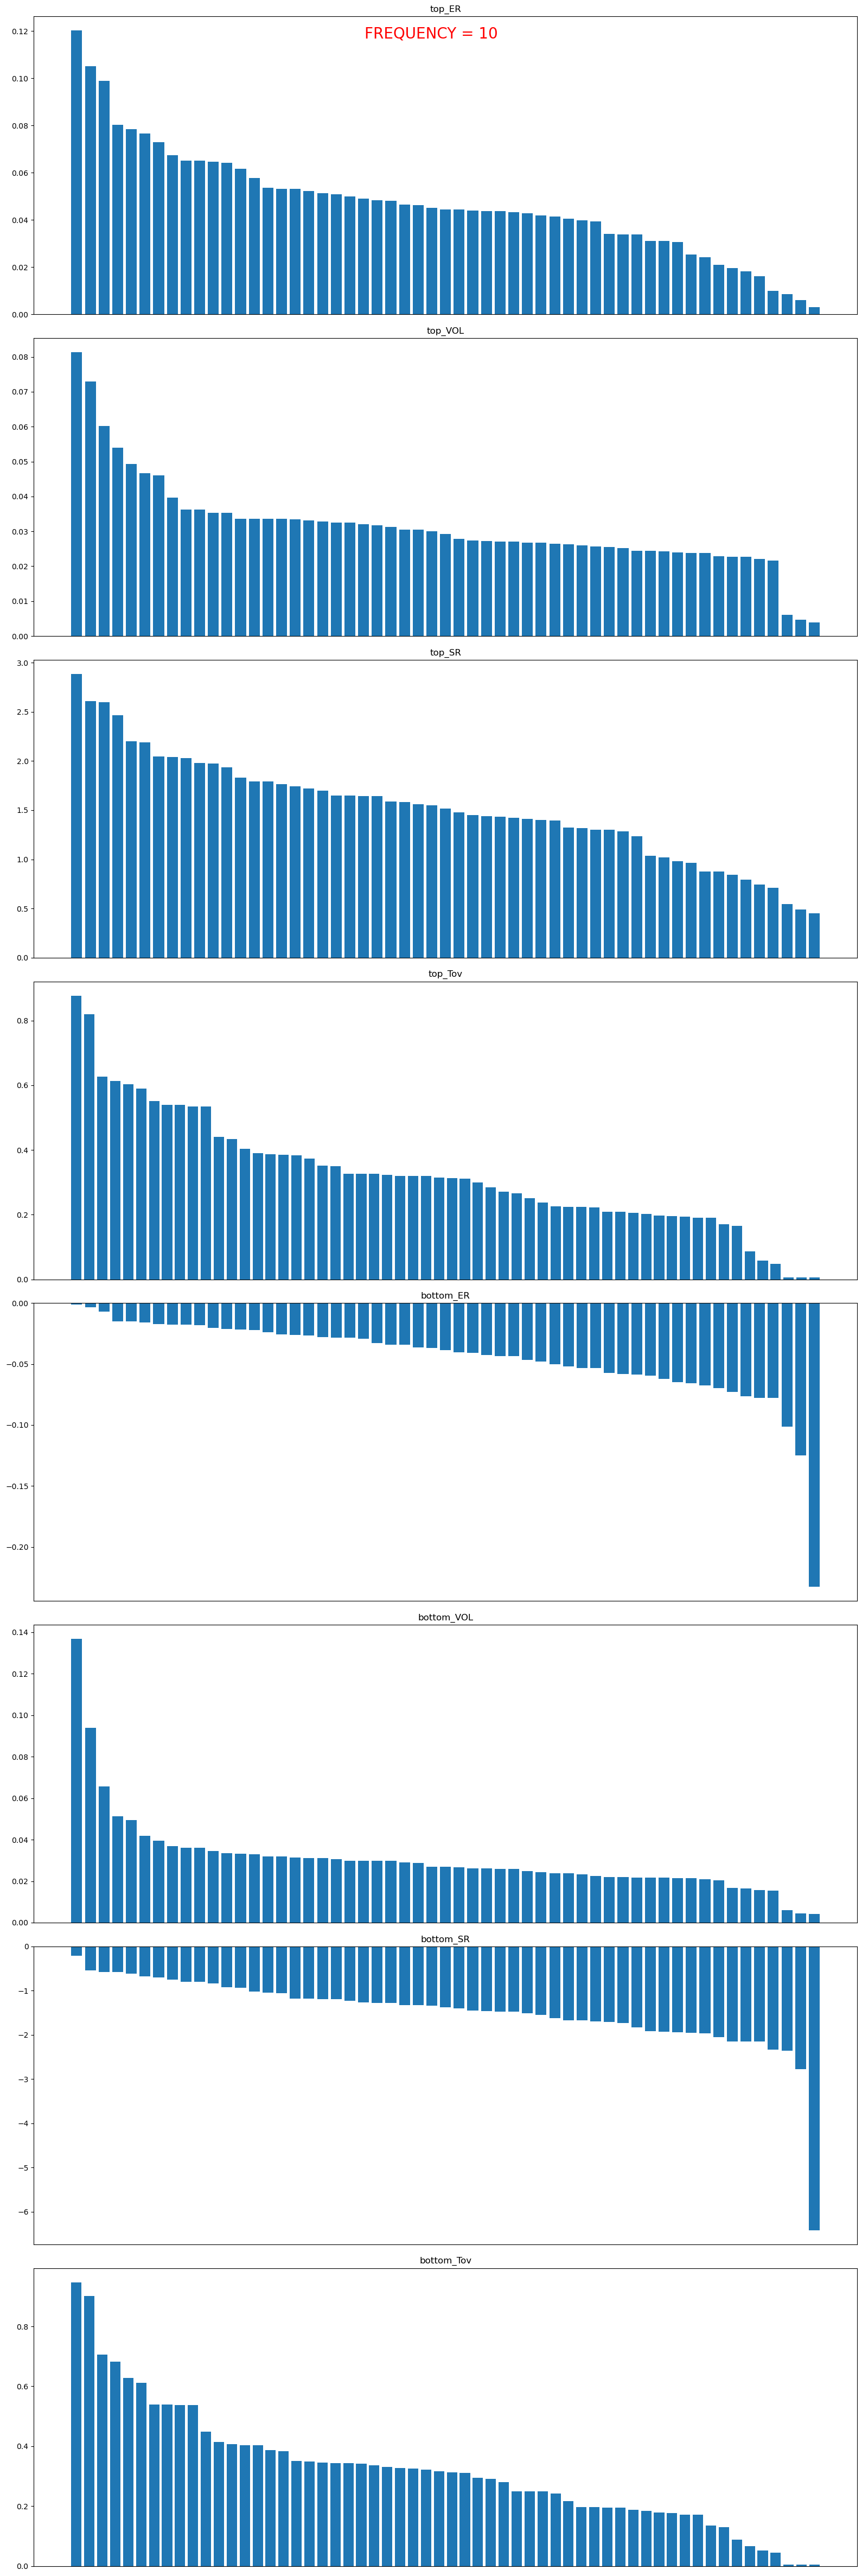

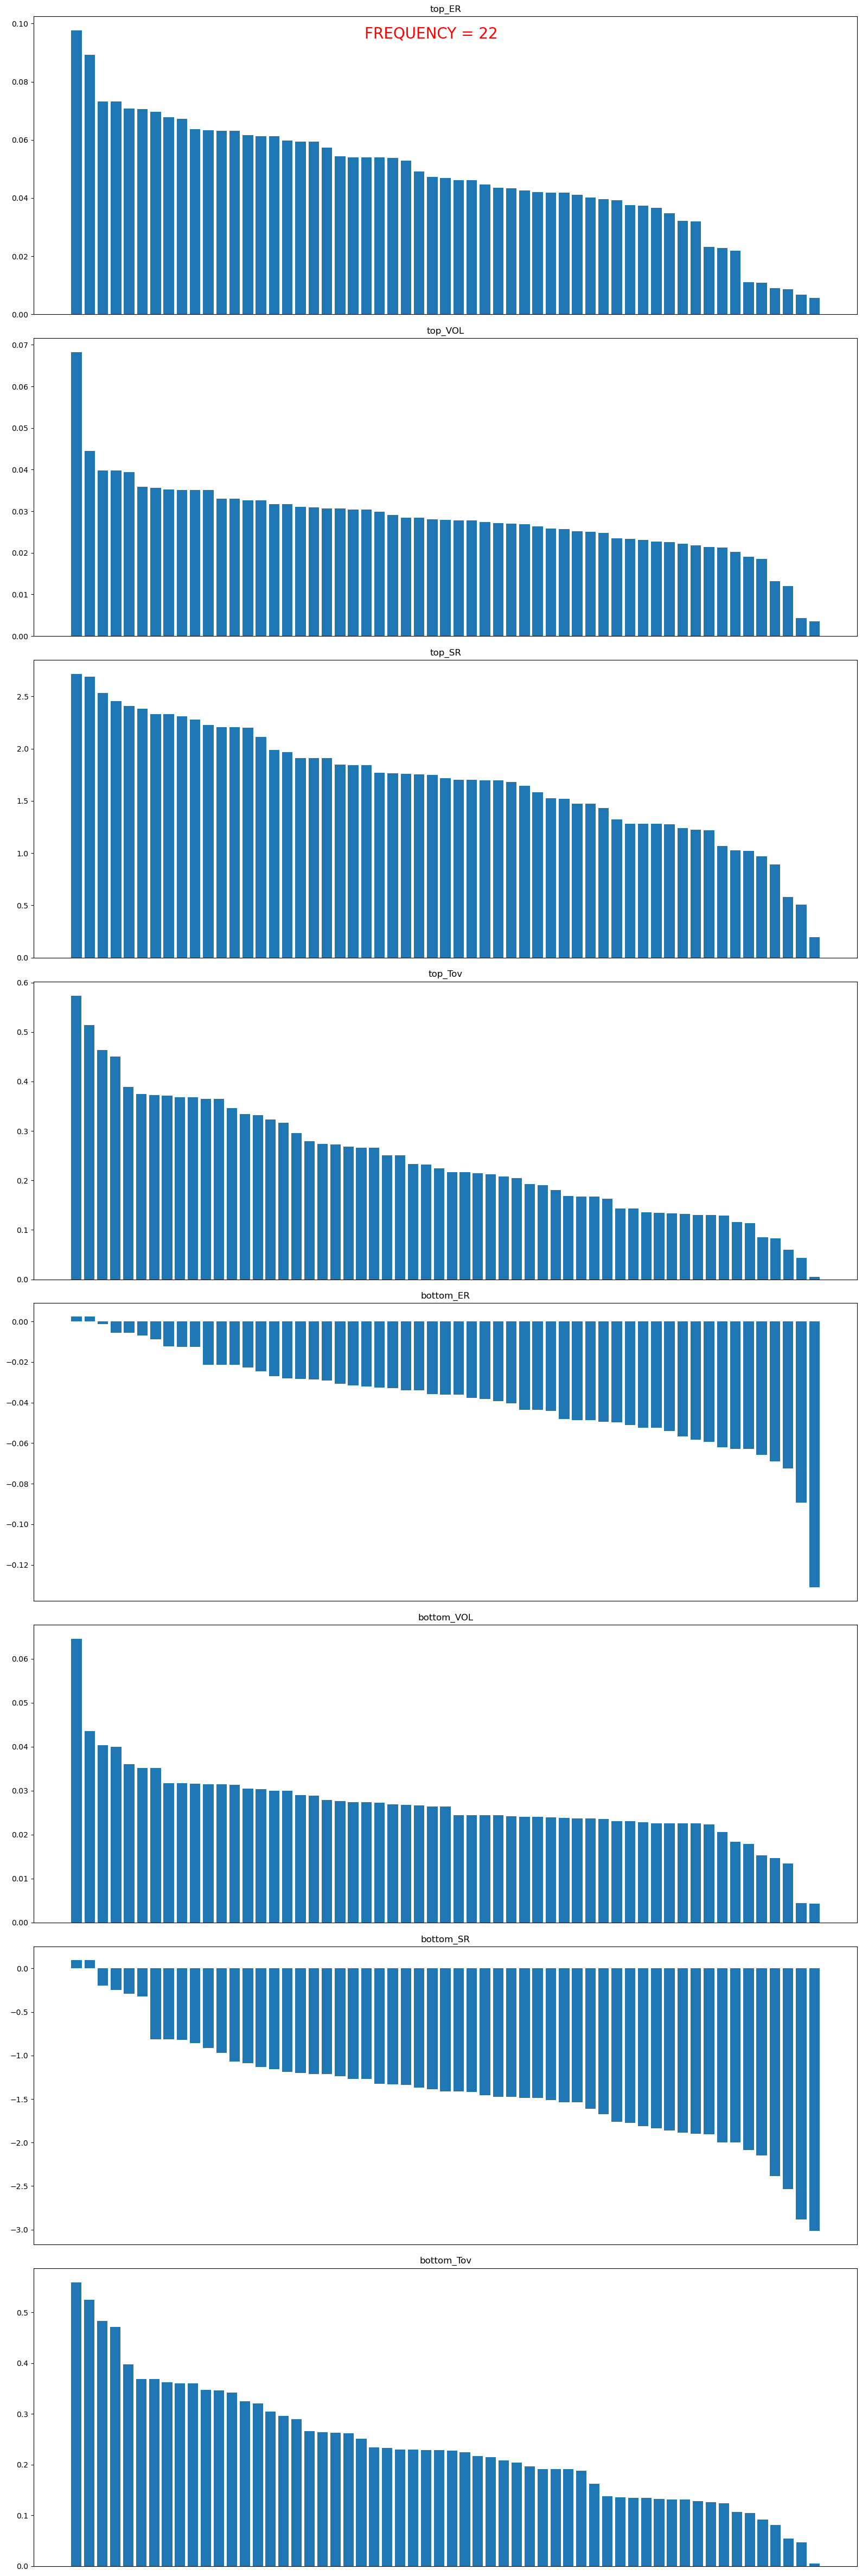

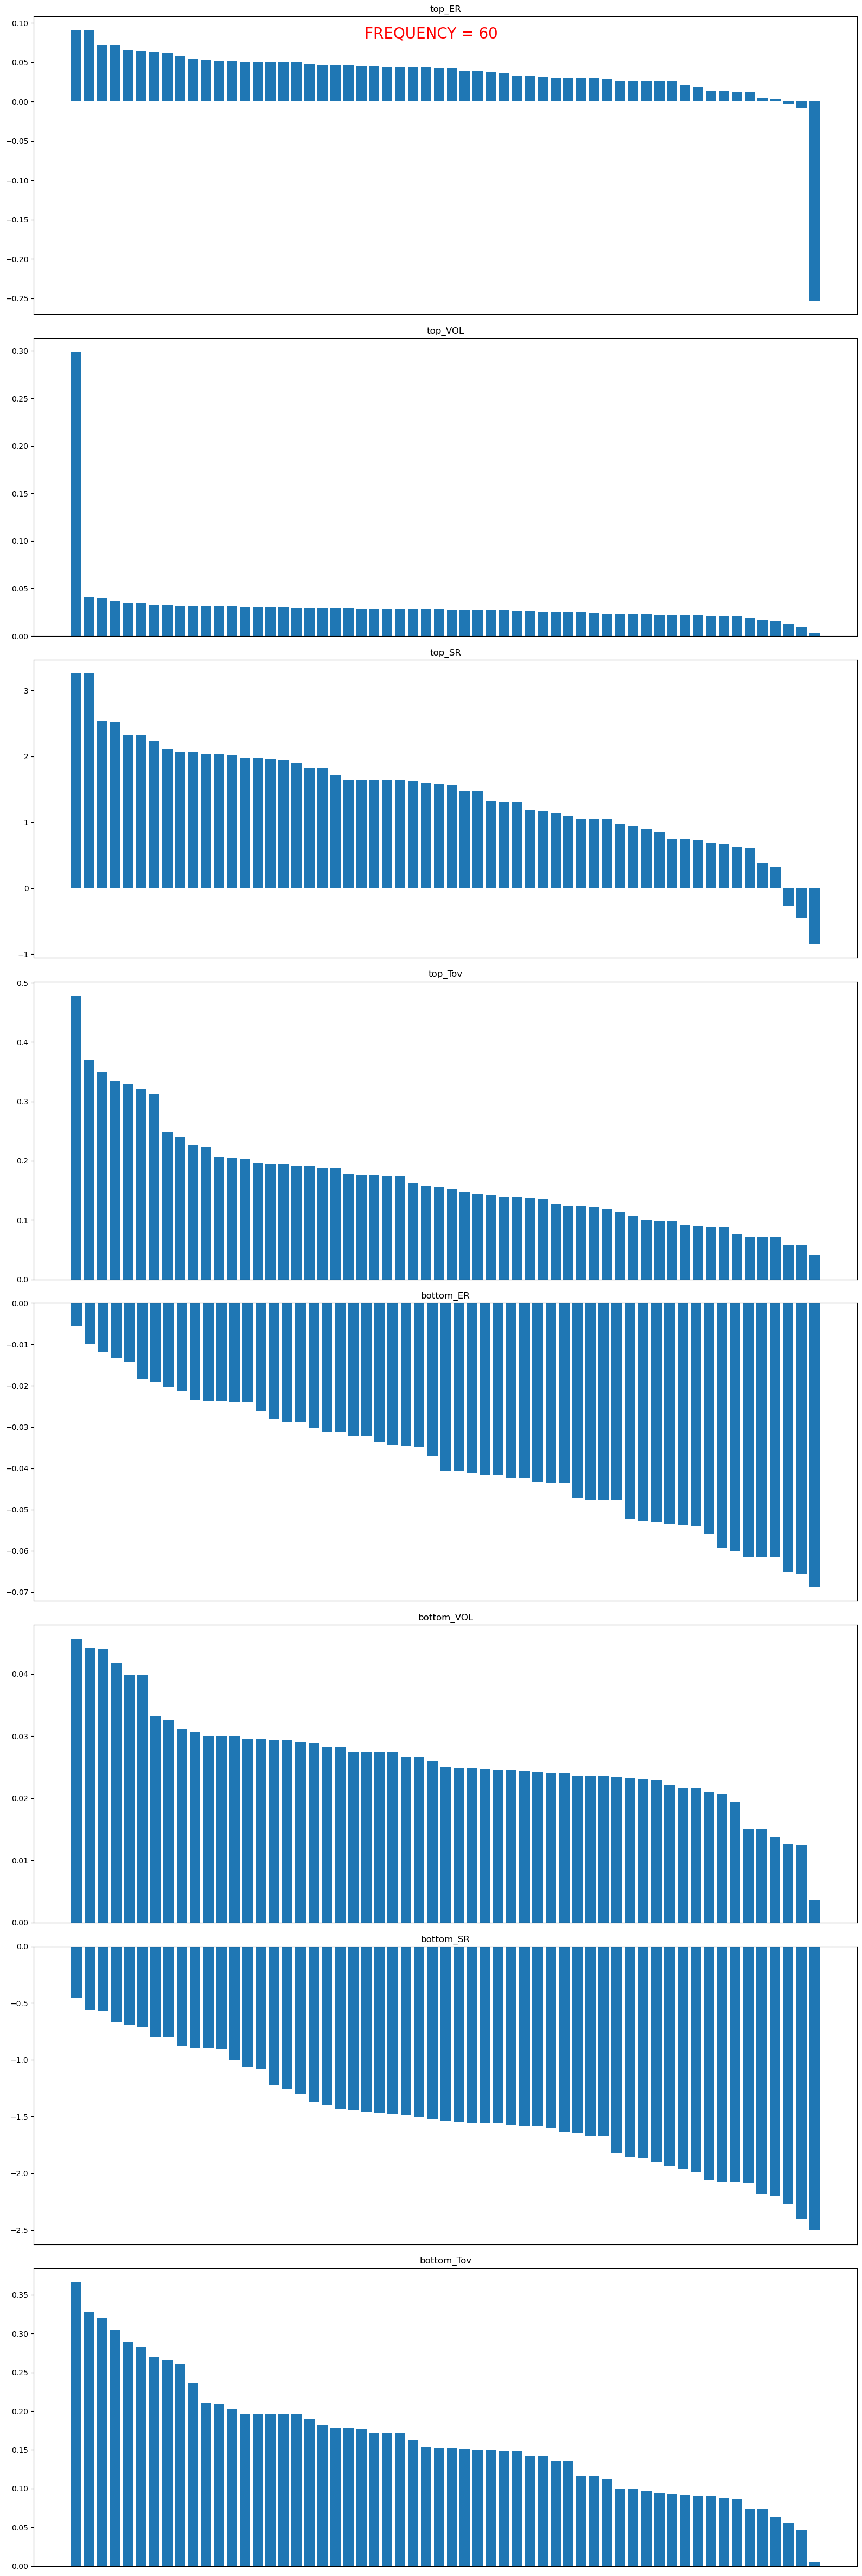

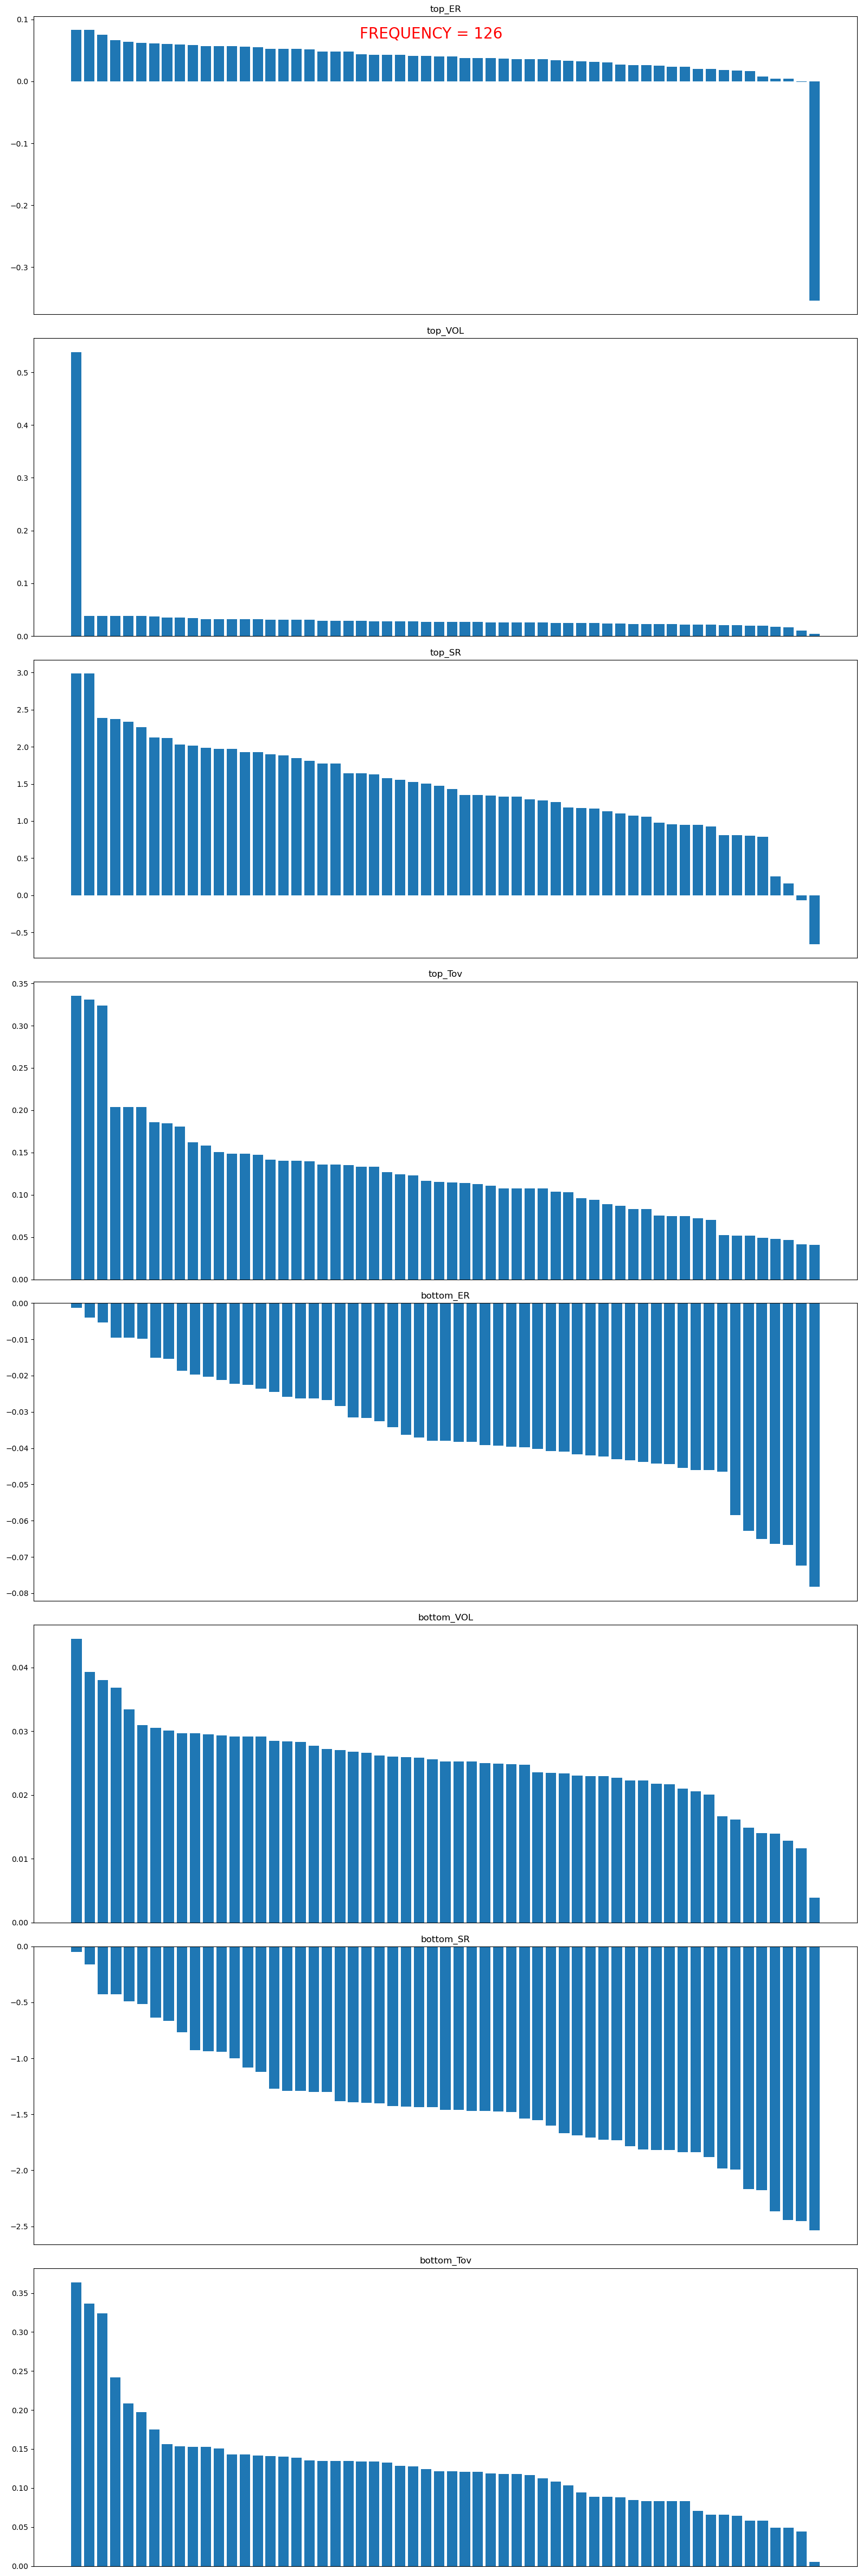

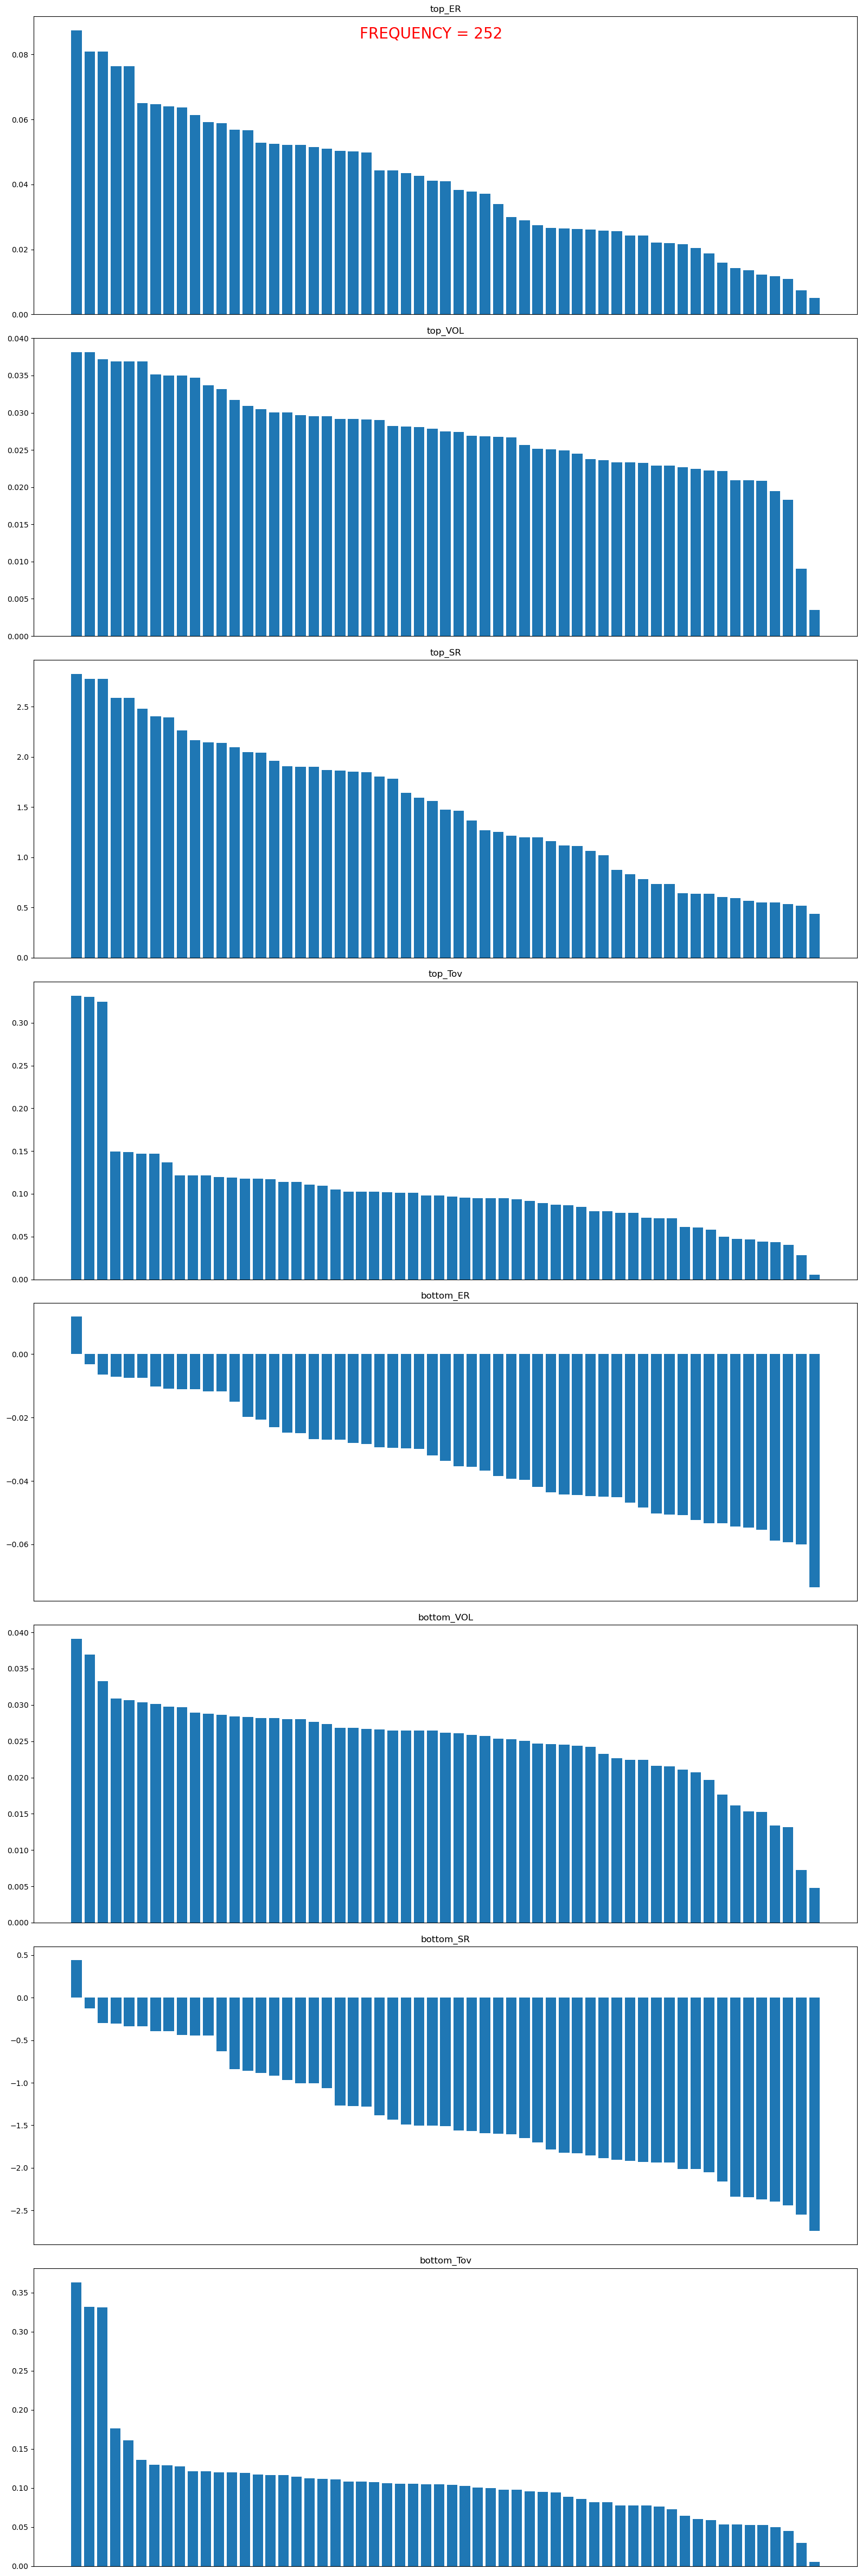

In [5]:
# 在每一个采样频率上对比不同的技术手段
window_group = XSMOM_report.groupby('window_label')
window_dict = dict(list(window_group))


ncols = 1
nrows = len(targets)

for freq, value in window_dict.items():
    
    i = 1
    plt.figure(figsize=(16, 6 * len(targets)))

    for name in targets:
        plt.subplot(nrows, ncols, i)
        x, y = value[name].sort_values(ascending=False).index, value[name].sort_values(ascending=False)
        x = value['function_name'][x]
        
        plt.bar(x,y)
        plt.xticks([])
        name = re.sub('[\u4e00-\u9fa5]', '', name)
        plt.title(name)
        i += 1

    
    plt.suptitle(f'FREQUENCY = {str(freq)}', fontsize=20,color='r')
    plt.tight_layout() 
    plt.savefig(f'FREQ_{str(freq)}.png')
    plt.show()

In [6]:
import skimage.io as io

pic = io.imread('FREQ_5.png')   # np.ndarray, [h, w, c], 值域[0, 255], RGB
length, width, num_channels = pic.shape

pj = np.zeros((length, width * len(time_windows),num_channels))

for i, time_window in enumerate(time_windows):
    current_pic = io.imread(f'FREQ_{time_window}.png')
    pj[:,i * width: (i + 1) * width , :] = current_pic.copy()
    
pj = np.array(pj ,dtype=np.uint8)
io.imsave('拼接的分采样频次的函数对比图.png', pj)

In [11]:
pic = io.imread('top_ER_sampling_freq.png')   # np.ndarray, [h, w, c], 值域[0, 255], RGB
length, width, num_channels = pic.shape

pj = np.zeros((length, width * len(targets),num_channels))
names = [re.sub('[\u4e00-\u9fa5]', '', name) for name in targets]

for i ,name in enumerate(names):
    current_pic = io.imread(f'{name}_sampling_freq.png')
    pj[:,i * width: (i + 1) * width , :] = current_pic.copy()
    
pj = np.array(pj ,dtype=np.uint8)
io.imsave('拼接的不同组别指标在采样频率上的横向对比图.png', pj)